In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

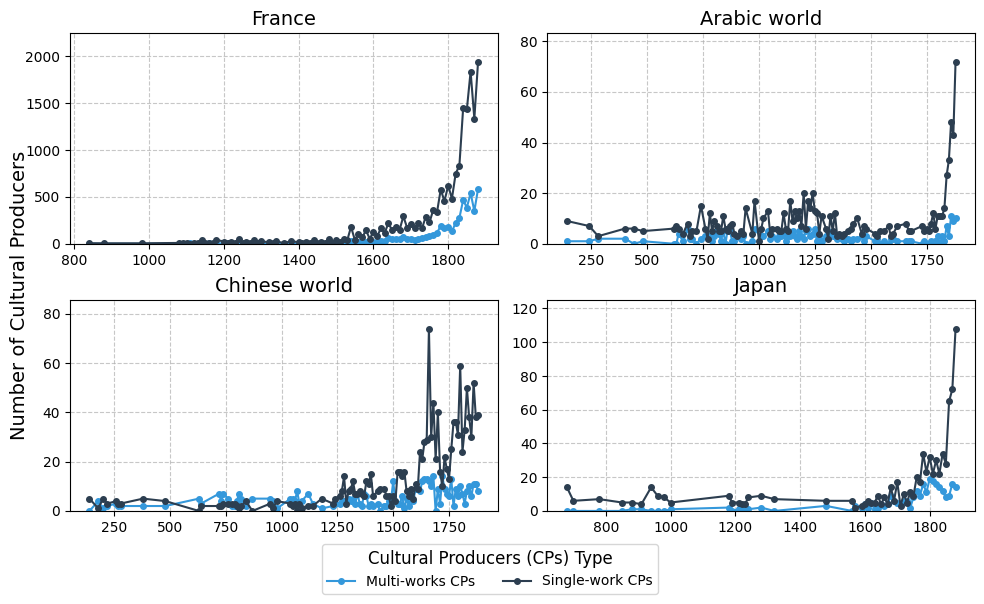

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../3-unseen_species_index/unseen_species_model/individuals_into_unseen_plus_>3.csv', index_col=[0])

# Select four interesting regions to compare
selected_regions = ['France', 'Arabic world', 'Chinese world', 'Japan']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# Store handles and labels for the legend
legend_handles = []
legend_labels = []

MIN_CPS = 5

final_data = []
# Process each region
for i, region in enumerate(selected_regions):
    # Filter data for the current region
    sample_test = df[df['region_name'] == region]
    sample_test = sample_test[['individual_wikidata_id', 'decade', 'count_works']].drop_duplicates()
    sample_test = sample_test.reset_index(drop=True)
    
    # Handle zero counts
    sample_test['count_works'][sample_test['count_works'] == 0] = 1
    
    # Classify contributors

    contributor_work_counts = sample_test.copy()
    contributor_work_counts['contributor_type'] = contributor_work_counts['count_works'].apply(
        lambda x: 'Single-work CPs' if x == 1 else 'Multi-works CPs')
    
    # Aggregate by decade and contributor type
    decade_contributor_analysis = contributor_work_counts.groupby(['decade', 'contributor_type']).agg(
        unique_contributors=('individual_wikidata_id', 'nunique'),
        total_works=('count_works', 'sum')
    ).reset_index()
    
    # Pivot the data for plotting
    contributors_pivot = decade_contributor_analysis.pivot(
        index='decade', columns='contributor_type', values='unique_contributors').fillna(0)
    

    contributors_pivot['total_cps'] = contributors_pivot['Multi-works CPs'] +contributors_pivot['Single-work CPs']
    contributors_pivot = contributors_pivot[contributors_pivot['total_cps']>=MIN_CPS] 
    contributors_pivot =contributors_pivot.drop('total_cps', axis=1)
    
    # Make sure both contributor types are present
    if 'Single-work CPs' not in contributors_pivot.columns:
        contributors_pivot['Single-work Cultural Producers'] = 0
    if 'Multi-works CPs' not in contributors_pivot.columns:
        contributors_pivot['Multi-works Cultural Producers'] = 0
    

    contributors_pivot['region_name']=region
    final_data.append(contributors_pivot)
    # Plot for the current region
    lines = contributors_pivot.plot(kind='line', marker='o', ax=axes[i], 
                           color=['#3498db', '#2c3e50'], linewidth=1.5, markersize=4,
                           legend=False)  # No legend for individual plots
    
    # Get handles and labels from the first plot only
    if i == 0:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    
    axes[i].set_title(f'{region}', fontsize=14)
    
    # Remove all y-labels from individual plots
    axes[i].set_ylabel('')
    
    # Set x-label only for bottom plots
    if i >= 2:  # For plots on the bottom (indices 2 and 3)
        axes[i].set_xlabel('', fontsize=12)
    else:
        axes[i].set_xlabel('')
    
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis to start from 0
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_ylim(0, y_max * 1.1)  # Add 10% padding at the top

# First, apply tight layout to get good spacing
plt.tight_layout()

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), 
           ncol=2, title='Cultural Producers (CPs) Type', fontsize=10, title_fontsize=12)

# Position the y-axis label closer to the figures
# Adjust the x-coordinate (first parameter) to move it closer to the plots
fig.text(0.02, 0.5, 'Number of Cultural Producers', va='center', rotation='vertical', fontsize=14)

# Adjust layout with space for the legend at the bottom
# Use a smaller left margin to keep the label closer to the plots
plt.subplots_adjust(bottom=0.14, left=0.08)

plt.show()

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Pour utiliser np.log1p

# Load data
df = pd.read_csv('../3-unseen_species_index/unseen_species_model/individuals_into_unseen_plus_>3.csv', index_col=[0])

# Select four interesting regions to compare
selected_regions = ['France', 'Arabic world', 'Chinese world', 'Japan']

df['decade'] = df['decade'].apply(lambda x: round(x / 50) * 50)
df = df[df['decade']<=1850]


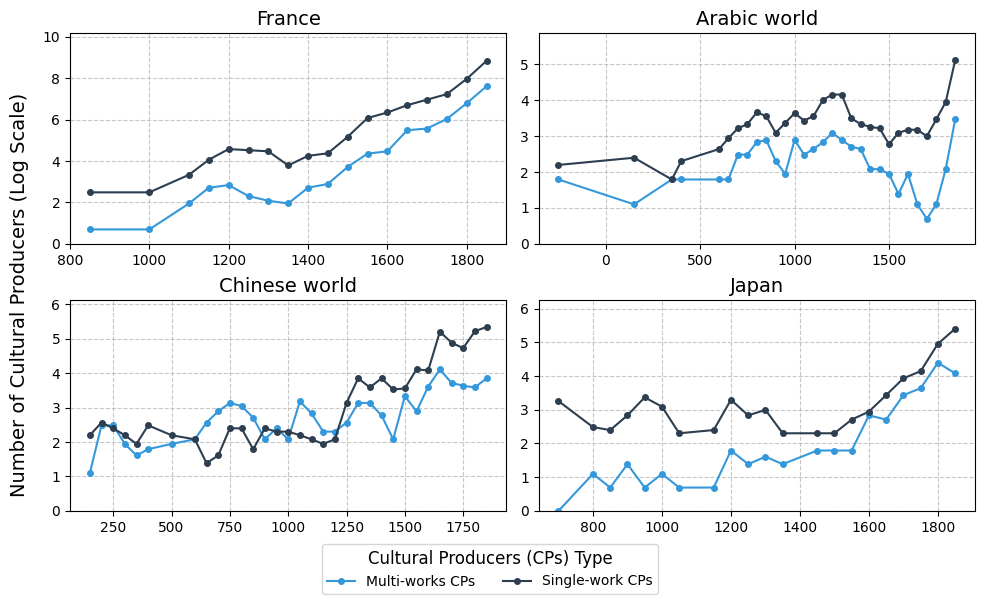

In [62]:


# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# Store handles and labels for the legend
legend_handles = []
legend_labels = []

MIN_CPS = 10

final_data = []
# Process each region
for i, region in enumerate(selected_regions):
    # Filter data for the current region
    sample_test = df[df['region_name'] == region]
    sample_test = sample_test[['individual_wikidata_id', 'decade', 'count_works']].drop_duplicates()
    sample_test = sample_test.reset_index(drop=True)
    
    # Handle zero counts
    sample_test['count_works'][sample_test['count_works'] == 0] = 1
    
    # Classify contributors
    contributor_work_counts = sample_test.copy()
    contributor_work_counts['contributor_type'] = contributor_work_counts['count_works'].apply(
        lambda x: 'Single-work CPs' if x == 1 else 'Multi-works CPs')
    
    # Aggregate by decade and contributor type
    decade_contributor_analysis = contributor_work_counts.groupby(['decade', 'contributor_type']).agg(
        unique_contributors=('individual_wikidata_id', 'nunique'),
        total_works=('count_works', 'sum')
    ).reset_index()
    
    # Pivot the data for plotting
    contributors_pivot = decade_contributor_analysis.pivot(
        index='decade', columns='contributor_type', values='unique_contributors').fillna(0)
    
    contributors_pivot['total_cps'] = contributors_pivot['Multi-works CPs'] + contributors_pivot['Single-work CPs']
    contributors_pivot = contributors_pivot[contributors_pivot['total_cps']>=MIN_CPS] 
    contributors_pivot = contributors_pivot.drop('total_cps', axis=1)
    
    # Make sure both contributor types are present
    if 'Single-work CPs' not in contributors_pivot.columns:
        contributors_pivot['Single-work Cultural Producers'] = 0
    if 'Multi-works CPs' not in contributors_pivot.columns:
        contributors_pivot['Multi-works Cultural Producers'] = 0
    
    # Apply log transformation to the data (log1p adds 1 before taking log to handle zeros)
    log_contributors_pivot = contributors_pivot.copy()
    log_contributors_pivot['Multi-works CPs'] = np.log1p(contributors_pivot['Multi-works CPs'])
    log_contributors_pivot['Single-work CPs'] = np.log1p(contributors_pivot['Single-work CPs'])
    
    log_contributors_pivot['region_name'] = region
    final_data.append(log_contributors_pivot)
    
    # Plot the log-transformed data
    lines = log_contributors_pivot.plot(kind='line', marker='o', ax=axes[i], 
                           color=['#3498db', '#2c3e50'], linewidth=1.5, markersize=4,
                           legend=False)
    
    # Get handles and labels from the first plot only
    if i == 0:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    
    axes[i].set_title(f'{region}', fontsize=14)
    
    # Remove all y-labels from individual plots
    axes[i].set_ylabel('')
    
    # Set x-label only for bottom plots
    if i >= 2:  # For plots on the bottom (indices 2 and 3)
        axes[i].set_xlabel('', fontsize=12)
    else:
        axes[i].set_xlabel('')
    
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis to start from 0
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_ylim(0, y_max * 1.1)  # Add 10% padding at the top

# First, apply tight layout to get good spacing
plt.tight_layout()

# Add a single legend to the figure
fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.01), 
           ncol=2, title='Cultural Producers (CPs) Type', fontsize=10, title_fontsize=12)

# Position the y-axis label closer to the figures
fig.text(0.02, 0.5, 'Number of Cultural Producers (Log Scale)', va='center', rotation='vertical', fontsize=14)

# Adjust layout with space for the legend at the bottom
plt.subplots_adjust(bottom=0.14, left=0.08)

plt.show()

In [64]:
final_df = pd.concat([x for x in final_data])
final_df = final_df.reset_index()
final_df.to_csv('db_extract/multi_work_single_work.csv')

In [66]:
final_df[final_df['region_name']=='Arabic world']

contributor_type,decade,Multi-works CPs,Single-work CPs,region_name
18,-250,1.79,2.20,Arabic world
19,150,1.10,2.40,Arabic world
20,350,1.79,1.79,Arabic world
21,400,1.79,2.30,Arabic world
22,600,1.79,2.64,Arabic world
23,650,1.79,2.94,Arabic world
24,700,2.48,3.22,Arabic world
25,750,2.48,3.33,Arabic world
26,800,2.83,3.66,Arabic world
27,850,2.89,3.56,Arabic world
